In [1]:
import optuna
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate

path_full = # INSERT PATH HERE

columns = ['T_e','T_bb','tau_T','E','Mu','I','U']

DF_full = pd.read_csv(path_full,names=columns)

In [12]:
def shuffle_and_split_dataframe(dataframe, train_ratio=0.70, validation_ratio=0.15, test_ratio=0.15, fraction=1.0):
    from sklearn.model_selection import train_test_split
    """Shuffles and splits a DataFrame into train, validation, and test sets.

    Args:
    dataframe: The DataFrame to be shuffled and split.
    train_size: The proportion of the DataFrame to include in the train set.
    validation_size: The proportion of the DataFrame to include in the validation set.
    test_size: The proportion of the DataFrame to include in the test set.
    fraction: The fraction of dataset that will be used, by default 1.0 (100%)

    Returns:
    A tuple of three DataFrames, representing the train, validation, and test sets.
    """

    # Shuffle the DataFrame.
    dataframe = dataframe.sample(frac=fraction,random_state=0)

    train_set, test_set = train_test_split(dataframe, test_size=(1 - train_ratio))
    validation_set, test_set = train_test_split(test_set, test_size = test_ratio/(test_ratio + validation_ratio) ) 
    
    # Return the train, validation, and test sets.
    return train_set, validation_set, test_set


def get_folds(DF,n_fold=2):
    """
    This function splits dataset into train, test and validation AND makes different folds.
    Parameters:
      DF - dataframe which should be splitted.
      n_folds - number of folds (default = 2), intiger.
    Return:
      Train_x, Test_x, Val_x - list of folds for features in training/test/validation sets
      Train_y, Test_y, Val_y - list of folds for labels in training/test/validation sets
    """

    # Number of folds. Means that the whole dataset is divided into n_fold parts of equal sizes.
    DF.reset_index(drop=True,inplace=True)
    X = DF.drop(['I','U'],axis=1)
    Y = np.log(DF['I'])

    # Create the KFold object.
    k_fold = KFold(n_splits=n_fold, shuffle=True,random_state=0)

    # Train and test indices for each fold:
    train_test_idx_in_folds = {k: (train, test) for k, (train, test) in enumerate(k_fold.split(DF))}

    # Choose indices of train and test sets from fold 0:
    fold = 0

    Train_x,Train_y =[],[]
    Test_x,Test_y = [],[]
    Val_x,Val_y = [],[]

    for i in range(n_fold):
        train_idx = train_test_idx_in_folds[i][0]
        test_idx = train_test_idx_in_folds[i][1]

        # I would like to have validation set. In this approach I'll naively split test set in two.
        # We could implement different way to split but I don't think that this is needed at this point.
        L = len(test_idx)//2

        # Pick input data for train and test sets (i.e., cleaned XRD intensities):
        Train_x.append(X.loc[train_idx])
        Test_x.append(X.loc[test_idx[:L]])
        Val_x.append(X.loc[test_idx[L:]])

        # Pick output data for train and test sets (i.e., sample dimensionalities):
        Train_y.append(Y.loc[train_idx])
        Test_y.append(Y.loc[test_idx[:L]])
        Val_y.append(Y.loc[test_idx[L:]])

    return(Train_x,Test_x,Val_x,Train_y,Test_y,Val_y)


def PredPlot_folds(model,Tr_x,Tr_y,Te_x,Te_y):
    """
    With this function I can iterate through the folds and execute fitting on each.
    Parameters:
      model - XGBRegression model
      Tr_x,Tr_Y,Te_x,Te_y - training and test data
      Validate - boolean value. If true model will be validated.
      Validation_set - data for validation (tuple of data)
      Verbose - set True to print out additional information
    """
    L = len(Tr_x)
    Y_pred = []
    for i in range(L):

        model.fit(Tr_x[i],Tr_y[i]) #This was modified for KRR, there is no verbose parameter

        pred = model.predict(Te_x[i])
        print('Fold',i,'MAE:',mean_absolute_error(Te_y[i],pred))
        Y_pred.append(pred)


    Scores_all = []
    f, ax = plt.subplots(1,L,figsize=[20,5])
    for i in range(L):
        ax[i].scatter(Te_y[i],Y_pred[i],s=5,c='k')
        maxmax = int(max(max(Te_y[i]),max(Y_pred[i])))
        minmin = int(min(min(Te_y[i]),min(Y_pred[i])))
        
        R2 = round(r2_score(Te_y[i],Y_pred[i]),4)
        MAE = round(mean_absolute_error(Te_y[i],Y_pred[i]),4)
        ax[i].plot([i for i in range(maxmax)],[i for i in range(maxmax)],c='r')
        ax[i].text(0,maxmax,'R2:'+str(R2))
        ax[i].text(0,maxmax*0.9,'MAE:'+str(MAE))
        Scores_all.append([R2,MAE])
    Scores_all = np.array(Scores_all)

    print('Mean R2:',np.mean(Scores_all[:,0]))
    print('Mean MAE:',np.mean(Scores_all[:,1]))

    return(Y_pred)

optuna.logging.set_verbosity(optuna.logging.WARNING)



def Plot_Pred(Y_test,pred):
    
    MAE = mean_absolute_error(Y_test,pred)
    R2 = r2_score(Y_test,pred)
    
    f, ax = plt.subplots(figsize=[10,6])
    ax.scatter(Y_test,pred,s=3,c='k')
    
    maxmax = int(max([max(Y_test),max(pred)]))
    minmin = int(min([min(Y_test),min(pred)]))
    
    ax.plot([i for i in range(minmin,maxmax)],[i for i in range(minmin,maxmax)],color='r')
    
    ax.set_ylabel('Predicted I')
    ax.set_xlabel('True I')
    
    _ = ax.text(minmin,maxmax,'MAE: '+str(MAE))
    _ = ax.text(minmin,maxmax*0.8,'R2: '+str(R2))

Here I define hyperparameter optimization for optuna

In [3]:
def objective(trial):
    param = {
        'alpha': trial.suggest_float('alpha', 10**-6, 10,log=True),
        'gamma': trial.suggest_float('gamma',10**-6,10,log=True),
        'kernel': trial.suggest_categorical('kernel',['rbf','laplacian','sigmoid','cosine','chi2','additive_chi2'])
        }
    model = KernelRidge(**param)
    model.fit(X_train, Y_train)
    y_pred = model.predict(X_test)
    return mean_absolute_error(Y_test, y_pred)

I will try to use kernel ridge regression to predict I value. I'll do this for increasing dataset size.

In [76]:
def objective_CV(trial):
    
    # In this version of objective I'm checking all folds and use mean MAE as scoring
    
    param = {
        'alpha': trial.suggest_float('alpha', 10**-6, 10,log=True),
        'gamma': trial.suggest_float('gamma',10**-6,10,log=True),
        'kernel': trial.suggest_categorical('kernel',['rbf','laplacian','sigmoid','cosine','chi2','additive_chi2'])
        }
    
    MAES = []
    model = KernelRidge(**param)
    L = len(Tr_x)
    
    for i in range(L):
        X_train, X_test = Tr_x[i], Te_x[i]
        Y_train, Y_test = Tr_y[i], Te_y[i]
        
        model.fit(X_train, Y_train)
        y_pred = model.predict(X_test)
        MAES.append(mean_absolute_error(Y_test,y_pred))
    
    
    return(np.mean(MAES))

In [4]:
# This variable will store the best hyperparameters for each dataset size
# This will enable me to enqueue trials with already known good parameters.
# It will also be used for data analysis at the end of this study.
TRIALS = []
# these my previous best results I'm putting them here just for safety
#TRIALS.append({'alpha': 1.1604365320235597e-06, 'gamma': 0.12692843989068256, 'kernel': 'chi2'})
#TRIALS.append({'alpha': 1.5595332644826417e-06, 'gamma': 0.24488952136988373, 'kernel': 'chi2'})
#TRIALS.append({'alpha': 1.003933272031719e-06, 'gamma': 0.22320911359899115, 'kernel': 'chi2'})

# 5K set Optuna

In [8]:
DF_5k = DF_full.sample(5000,random_state=0)
Tr_x,Te_x,V_x,Tr_y,Te_y,V_y = get_folds(DF_5k,n_fold=3)

In [78]:
#We need to be really careful when calling optuna parameter range.

DF_5k = DF_full.sample(5000,random_state=0)
Tr_x,Te_x,V_x,Tr_y,Te_y,V_y = get_folds(DF_5k,n_fold=3)
X_train,X_test,X_val,Y_train,Y_test,Y_val = Tr_x[0],Te_x[0],V_x[0],Tr_y[0],Te_y[0],V_y[0]
study = optuna.create_study(direction='minimize', study_name='regression')
param = study.optimize(objective, n_trials=50)
params = study.best_params
val = study.best_value
print('Best value:',val)
print('Best parameters:\n',params)

[I 2023-11-08 14:22:50,802] A new study created in memory with name: regression
C:\Users\togali\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:250: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
[I 2023-11-08 14:23:04,701] Trial 0 finished with value: 1.6016612951454792 and parameters: {'alpha': 5.834106888010725e-05, 'gamma': 1.8028733802926698e-05, 'kernel': 'additive_chi2'}. Best is trial 0 with value: 1.6016612951454792.
[I 2023-11-08 14:23:05,040] Trial 1 finished with value: 1.691587135287766 and parameters: {'alpha': 0.01445861789565154, 'gamma': 0.001623696569774507, 'kernel': 'cosine'}. Best is trial 0 with value: 1.6016612951454792.
[I 2023-11-08 14:23:05,506] Trial 2 finished with value: 2.0390311297182087 and parameters: {'alpha': 0.06570999767869048, 'gamma': 0.0002115742881451119, 'kernel': 'laplacian'}. Best is trial 0 with value: 1.6016612951454792.
[I 2023-11-08 14:23:05,982] Trial 

[I 2023-11-08 14:24:01,234] Trial 33 finished with value: 0.08307677617609027 and parameters: {'alpha': 2.5642177259175855e-06, 'gamma': 0.17080992434925804, 'kernel': 'chi2'}. Best is trial 14 with value: 0.07197950556099941.
[I 2023-11-08 14:24:01,713] Trial 34 finished with value: 0.2885341727626843 and parameters: {'alpha': 8.83766182791305e-06, 'gamma': 0.004332218671575319, 'kernel': 'chi2'}. Best is trial 14 with value: 0.07197950556099941.
[I 2023-11-08 14:24:02,056] Trial 35 finished with value: 1.7268339348455612 and parameters: {'alpha': 3.894005944159865e-06, 'gamma': 0.0009677554622289927, 'kernel': 'cosine'}. Best is trial 14 with value: 0.07197950556099941.
[I 2023-11-08 14:24:02,537] Trial 36 finished with value: 0.6014868649710089 and parameters: {'alpha': 2.9124749669610056e-06, 'gamma': 0.03820435752676934, 'kernel': 'laplacian'}. Best is trial 14 with value: 0.07197950556099941.
[I 2023-11-08 14:24:03,051] Trial 37 finished with value: 0.07636148715364484 and parame

Best value: 0.07197950556099941
Best parameters:
 {'alpha': 1.1604365320235597e-06, 'gamma': 0.12692843989068256, 'kernel': 'chi2'}


In [ ]:
KRR = KernelRidge(**params)
KRR.fit(X_train,Y_train)
pred = KRR.predict(X_test)
MAE = mean_absolute_error(Y_test,pred)
R2 = r2_score(Y_test,pred)

Plot_Pred(Y_test,pred)

Fold 0 MAE: 0.07197950556099941
Fold 1 MAE: 0.06832430611465072
Fold 2 MAE: 0.06945396408403663
Mean R2: 0.9990333333333333
Mean MAE: 0.06993333333333333


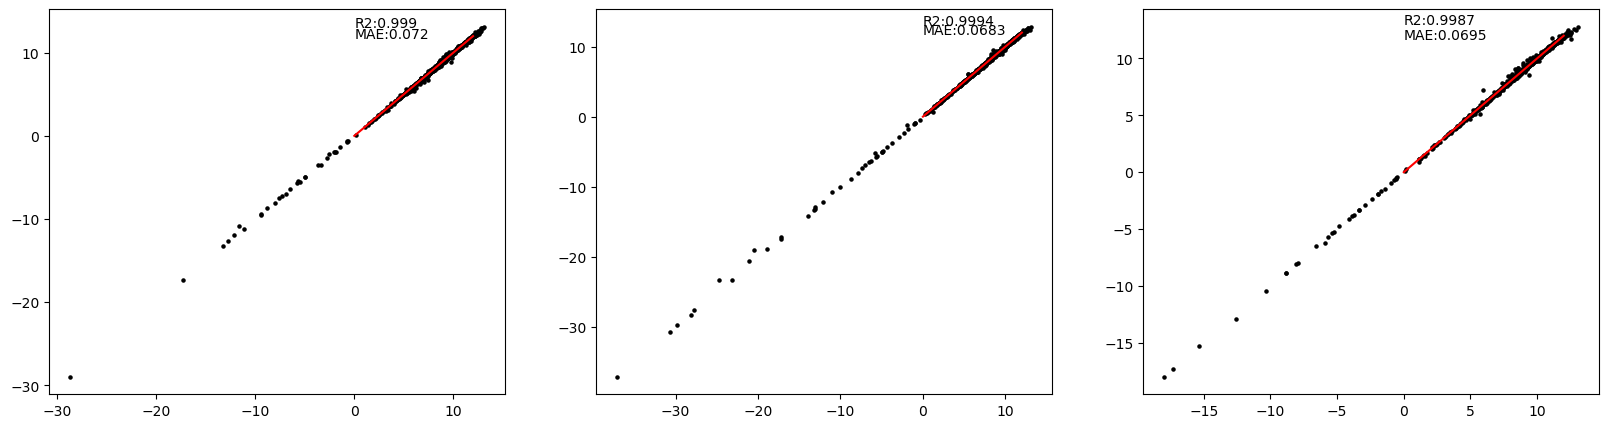

In [80]:
KRR = KernelRidge(**params)
_ = PredPlot_folds(KRR,Tr_x,Tr_y,Te_x,Te_y)

### Cross validated objective

In [81]:
X_train,X_test,X_val,Y_train,Y_test,Y_val = Tr_x[0],Te_x[0],V_x[0],Tr_y[0],Te_y[0],V_y[0]
study = optuna.create_study(direction='minimize', study_name='regression')
param = study.optimize(objective_corss_validated, n_trials=50)
params = study.best_params
val = study.best_value
print('Best value:',val)
print('Best parameters:\n',params)

[I 2023-11-08 14:26:21,439] A new study created in memory with name: regression
[I 2023-11-08 14:26:22,796] Trial 0 finished with value: 2.0677318684697963 and parameters: {'alpha': 1.4008555761843804, 'gamma': 0.003312562280046559, 'kernel': 'chi2'}. Best is trial 0 with value: 2.0677318684697963.
[I 2023-11-08 14:26:24,046] Trial 1 finished with value: 2.649035594522515 and parameters: {'alpha': 5.609548268790272e-06, 'gamma': 7.874716737068042, 'kernel': 'sigmoid'}. Best is trial 0 with value: 2.0677318684697963.
C:\Users\togali\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:250: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
C:\Users\togali\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:250: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
C:\Users\togali\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear

[I 2023-11-08 14:28:43,764] Trial 28 finished with value: 2.649035578208671 and parameters: {'alpha': 1.0163027347771797e-05, 'gamma': 0.21160637161599885, 'kernel': 'sigmoid'}. Best is trial 25 with value: 0.1303391750995907.
[I 2023-11-08 14:28:45,133] Trial 29 finished with value: 0.512496172637295 and parameters: {'alpha': 4.918377990985268e-06, 'gamma': 1.9926834755173253, 'kernel': 'chi2'}. Best is trial 25 with value: 0.1303391750995907.
[I 2023-11-08 14:28:46,101] Trial 30 finished with value: 1.711055755185372 and parameters: {'alpha': 3.765924822183138e-05, 'gamma': 6.963322365485939, 'kernel': 'cosine'}. Best is trial 25 with value: 0.1303391750995907.
[I 2023-11-08 14:28:47,474] Trial 31 finished with value: 0.1920165810896958 and parameters: {'alpha': 0.00010683022517367088, 'gamma': 0.2775540762257815, 'kernel': 'chi2'}. Best is trial 25 with value: 0.1303391750995907.
[I 2023-11-08 14:28:48,839] Trial 32 finished with value: 0.1871642610277884 and parameters: {'alpha': 8

Best value: 0.08045545895011927
Best parameters:
 {'alpha': 2.077867276606827e-06, 'gamma': 0.1318875624991601, 'kernel': 'chi2'}


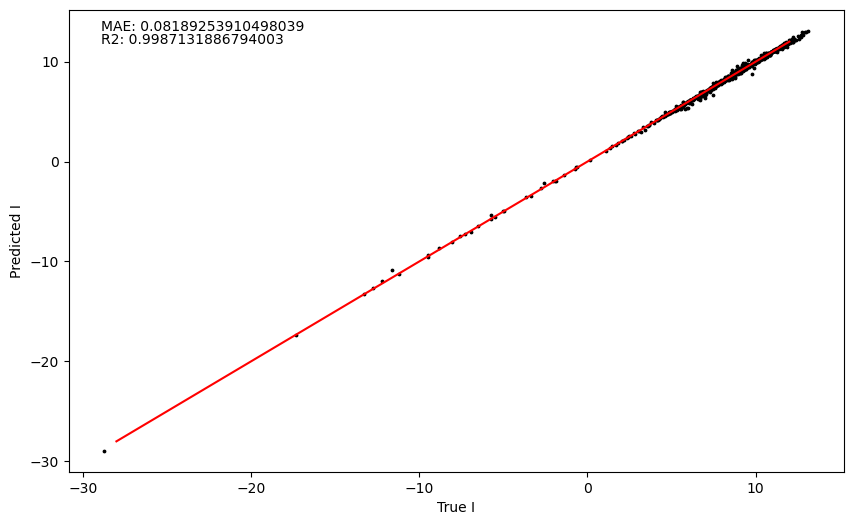

In [82]:
KRR = KernelRidge(**params)

KRR.fit(X_train,Y_train)
pred = KRR.predict(X_test)
MAE = mean_absolute_error(Y_test,pred)
R2 = r2_score(Y_test,pred)

Plot_Pred(Y_test,pred)

Fold 0 MAE: 0.08189253910498039
Fold 1 MAE: 0.07913268932437979
Fold 2 MAE: 0.08034114842099763
Mean R2: 0.9987666666666666
Mean MAE: 0.08043333333333334


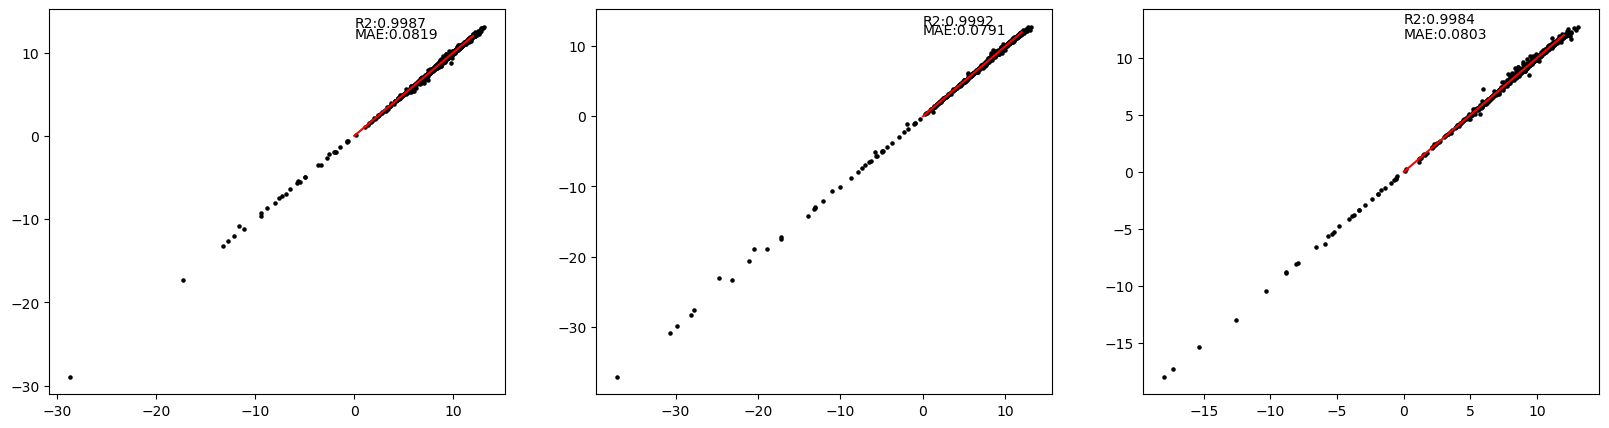

In [83]:
_ = PredPlot_folds(KRR,Tr_x,Tr_y,Te_x,Te_y)

It seems that cross validated objective didn't made such difference for 5K set. I'll repeat with larger datasets. This might work much better if I increase number of optimizations to eg 100.

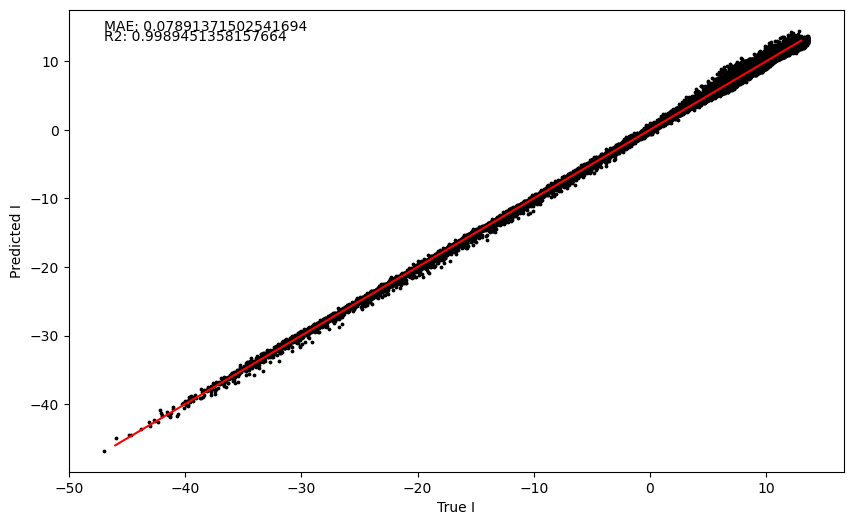

In [89]:
# Can't run on full dataset which is 18M due to memory issues (would need 75GB) but I can do this for 5M dataset. 

DF_5M = DF_full.sample(5000000,random_state=0)
Tr_x,Te_x,V_x,Tr_y,Te_y,V_y = get_folds(DF_5M,n_fold=3)
X_train,X_test,X_val,Y_train,Y_test,Y_val = Tr_x[0],Te_x[0],V_x[0],Tr_y[0],Te_y[0],V_y[0]
#KRR = KernelRidge(**params)

#KRR.fit(X_train,Y_train)
pred = KRR.predict(X_test)
MAE = mean_absolute_error(Y_test,pred)
R2 = r2_score(Y_test,pred)

Plot_Pred(Y_test,pred)

The best parameters I have seen so far:
{'alpha': 1.1604365320235597e-06, 'gamma': 0.12692843989068256, 'kernel': 'chi2'}
Which gives us MAE 0.079 and R2 0.999 with 5M dataset. It is smashing all previous models.

# 10K set

In [90]:
from time import time
start = time()
# Using above results I will repeat the search with limited parameters
DF_10k = DF_full.sample(10000,random_state=0)
Tr_x,Te_x,V_x,Tr_y,Te_y,V_y = get_folds(DF_10k,n_fold=3)

X_train,X_test,X_val,Y_train,Y_test,Y_val = Tr_x[0],Te_x[0],V_x[0],Tr_y[0],Te_y[0],V_y[0]
study = optuna.create_study(direction='minimize', study_name='regression')
param = study.optimize(objective, n_trials=100)
params = study.best_params
val = study.best_value
print('Best value:',val)
print('Best parameters:\n',params)
print('Execution time in seconds:',time()-start,'In minutes:',(time()-start)//60)

[I 2023-11-08 14:43:26,788] A new study created in memory with name: regression
[I 2023-11-08 14:43:29,938] Trial 0 finished with value: 1.2679629057250386 and parameters: {'alpha': 1.721479200702332e-06, 'gamma': 0.0002774205908048336, 'kernel': 'rbf'}. Best is trial 0 with value: 1.2679629057250386.
[I 2023-11-08 14:43:31,890] Trial 1 finished with value: 1.6635676807618973 and parameters: {'alpha': 9.13086200878461e-06, 'gamma': 0.0038389267153558487, 'kernel': 'cosine'}. Best is trial 0 with value: 1.2679629057250386.
C:\Users\togali\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:250: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
[I 2023-11-08 14:45:22,570] Trial 2 finished with value: 5.853336423846252 and parameters: {'alpha': 3.717092682336333e-05, 'gamma': 0.0001616354815293838, 'kernel': 'sigmoid'}. Best is trial 0 with value: 1.2679629057250386.
[I 2023-11-08 14:45:24,674] Trial 3 finishe

[I 2023-11-08 14:52:17,384] Trial 32 finished with value: 0.33677382702353487 and parameters: {'alpha': 3.804342340743313e-06, 'gamma': 0.003676459105448619, 'kernel': 'laplacian'}. Best is trial 31 with value: 0.3352013426461511.
C:\Users\togali\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:250: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
[I 2023-11-08 14:53:59,673] Trial 33 finished with value: 1.4701324209282547 and parameters: {'alpha': 3.1842662029405083e-06, 'gamma': 0.002819747424237669, 'kernel': 'additive_chi2'}. Best is trial 31 with value: 0.3352013426461511.
[I 2023-11-08 14:54:02,417] Trial 34 finished with value: 0.47561516983525837 and parameters: {'alpha': 1.1141630625818882e-06, 'gamma': 0.028074528416204926, 'kernel': 'laplacian'}. Best is trial 31 with value: 0.3352013426461511.
[I 2023-11-08 14:54:04,375] Trial 35 finished with value: 1.6572346107541753 and parameters: {'alph

[I 2023-11-08 14:57:34,935] Trial 67 finished with value: 3.6569925708975384 and parameters: {'alpha': 4.51536560246534e-05, 'gamma': 2.7066031424309878, 'kernel': 'rbf'}. Best is trial 59 with value: 0.11629569899969706.
[I 2023-11-08 14:57:37,941] Trial 68 finished with value: 0.1750807231828023 and parameters: {'alpha': 0.00039633033127116807, 'gamma': 0.7444809300579891, 'kernel': 'chi2'}. Best is trial 59 with value: 0.11629569899969706.
[I 2023-11-08 14:57:40,184] Trial 69 finished with value: 1.6680435311478428 and parameters: {'alpha': 8.788595863093516e-05, 'gamma': 0.49260090040973864, 'kernel': 'cosine'}. Best is trial 59 with value: 0.11629569899969706.
[I 2023-11-08 14:57:42,744] Trial 70 finished with value: 0.10018905690444355 and parameters: {'alpha': 5.0131503521234864e-05, 'gamma': 0.4241243114121866, 'kernel': 'chi2'}. Best is trial 70 with value: 0.10018905690444355.
[I 2023-11-08 14:57:44,932] Trial 71 finished with value: 0.1282457056666425 and parameters: {'alpha

Best value: 0.04382734602807617
Best parameters:
 {'alpha': 1.5595332644826417e-06, 'gamma': 0.24488952136988373, 'kernel': 'chi2'}
Execution time in seconds: 1149.2952337265015 In minutes: 19.0


Fold 0 MAE: 0.04382734602807617
Fold 1 MAE: 0.04471633018451509
Fold 2 MAE: 0.04662643081973477
Mean R2: 0.9996333333333333
Mean MAE: 0.045033333333333335


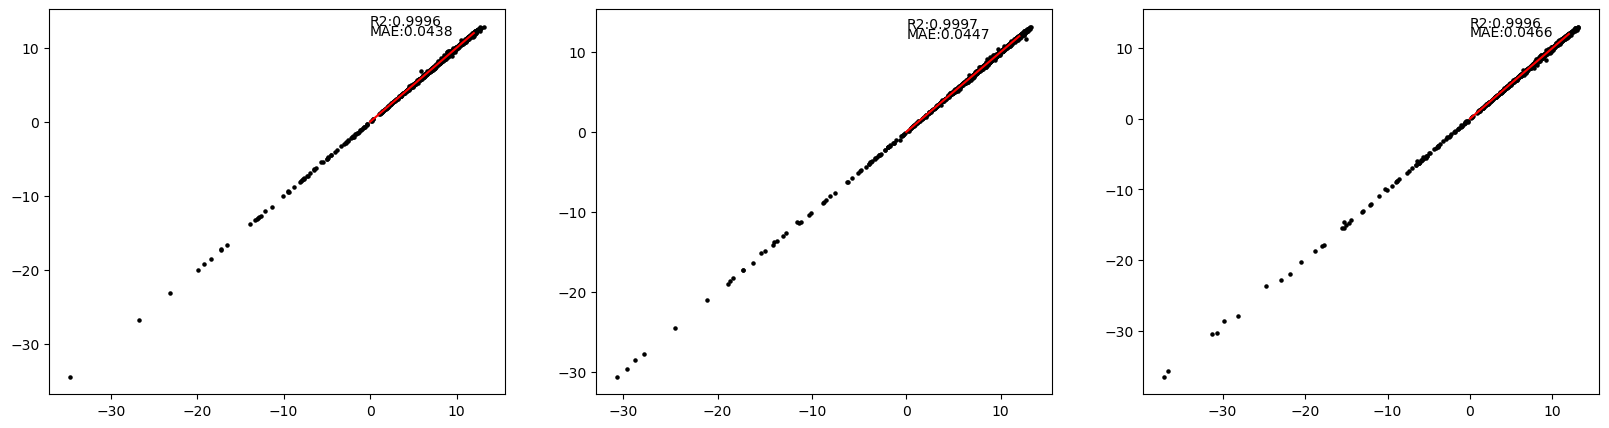

In [91]:
KRR = KernelRidge(**params)
_ = PredPlot_folds(KRR,Tr_x,Tr_y,Te_x,Te_y)

### Cross validated optimization

I don't think this will make any difference, so I'm ommiting it so far. We have good model even without such validation.

Best parameters:
 {'alpha': 1.5595332644826417e-06, 'gamma': 0.24488952136988373, 'kernel': 'chi2'}
Execution time in seconds: 1149.2952337265015 In minutes: 19.0

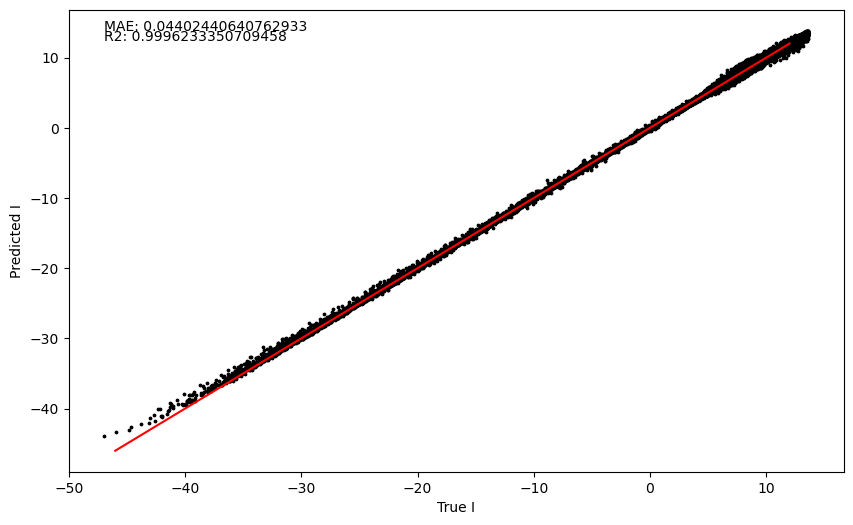

In [92]:
# Can't run on full dataset which is 18M due to memory issues (would need 75GB) but I can do this for 5M dataset. 

DF_5M = DF_full.sample(5000000,random_state=0)
Tr_x,Te_x,V_x,Tr_y,Te_y,V_y = get_folds(DF_5M,n_fold=3)
X_train,X_test,X_val,Y_train,Y_test,Y_val = Tr_x[0],Te_x[0],V_x[0],Tr_y[0],Te_y[0],V_y[0]
#KRR = KernelRidge(**params)

#KRR.fit(X_train,Y_train)
pred = KRR.predict(X_test)
MAE = mean_absolute_error(Y_test,pred)
R2 = r2_score(Y_test,pred)

Plot_Pred(Y_test,pred)

# 15K set

In [97]:
from time import time
start = time()
# Using above results I will repeat the search with limited parameters
DF_15k = DF_full.sample(15000,random_state=0)
Tr_x,Te_x,V_x,Tr_y,Te_y,V_y = get_folds(DF_15k,n_fold=3)

X_train,X_test,X_val,Y_train,Y_test,Y_val = Tr_x[0],Te_x[0],V_x[0],Tr_y[0],Te_y[0],V_y[0]
study = optuna.create_study(direction='minimize', study_name='regression')

#This function will use previous best parameters as starting point
for T in TRIALS:
    study.enqueue_trial(T)
    
param = study.optimize(objective, n_trials=100)
params = study.best_params
val = study.best_value
print('Best value:',val)
print('Best parameters:\n',params)
print('Execution time in seconds:',time()-start,'In minutes:',(time()-start)//60)
TRIALS.append(params)

[I 2023-11-08 15:22:59,603] A new study created in memory with name: regression
[I 2023-11-08 15:23:01,610] Trial 0 finished with value: 0.044743438423011046 and parameters: {'alpha': 1.1604365320235597e-06, 'gamma': 0.12692843989068256, 'kernel': 'chi2'}. Best is trial 0 with value: 0.044743438423011046.
[I 2023-11-08 15:23:03,636] Trial 1 finished with value: 0.04382734602807617 and parameters: {'alpha': 1.5595332644826417e-06, 'gamma': 0.24488952136988373, 'kernel': 'chi2'}. Best is trial 1 with value: 0.04382734602807617.
[I 2023-11-08 15:23:05,235] Trial 2 finished with value: 1.6650493949766418 and parameters: {'alpha': 0.004632685520729619, 'gamma': 0.0010463093199892086, 'kernel': 'cosine'}. Best is trial 1 with value: 0.04382734602807617.
[I 2023-11-08 15:23:07,386] Trial 3 finished with value: 1.558022799953204 and parameters: {'alpha': 0.0006267138258412931, 'gamma': 0.00013858202166773084, 'kernel': 'rbf'}. Best is trial 1 with value: 0.04382734602807617.
[I 2023-11-08 15:2

[I 2023-11-08 15:30:36,277] Trial 34 finished with value: 4.47869250837413 and parameters: {'alpha': 8.602643434098289e-06, 'gamma': 1.7662490983274564, 'kernel': 'rbf'}. Best is trial 22 with value: 0.042761185167068706.
[I 2023-11-08 15:30:38,713] Trial 35 finished with value: 0.312858854878748 and parameters: {'alpha': 1.1424512046835948e-05, 'gamma': 0.0016149869293968857, 'kernel': 'chi2'}. Best is trial 22 with value: 0.042761185167068706.
[I 2023-11-08 15:30:41,027] Trial 36 finished with value: 2.537199135413916 and parameters: {'alpha': 3.0262863767354493e-06, 'gamma': 0.20362167706321874, 'kernel': 'sigmoid'}. Best is trial 22 with value: 0.042761185167068706.
C:\Users\togali\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:250: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
[I 2023-11-08 15:32:20,407] Trial 37 finished with value: 1.466934048099968 and parameters: {'alpha': 0.00022205055754

[I 2023-11-08 15:37:47,745] Trial 68 finished with value: 2.537199295666206 and parameters: {'alpha': 1.5663914570421854e-06, 'gamma': 0.6614172816819361, 'kernel': 'sigmoid'}. Best is trial 22 with value: 0.042761185167068706.
[I 2023-11-08 15:37:50,629] Trial 69 finished with value: 0.09083738256731282 and parameters: {'alpha': 3.9569342708744e-06, 'gamma': 0.05592919468803838, 'kernel': 'chi2'}. Best is trial 22 with value: 0.042761185167068706.
[I 2023-11-08 15:37:53,431] Trial 70 finished with value: 0.13521981923637622 and parameters: {'alpha': 1.5466261492809712e-06, 'gamma': 1.4211930946232112, 'kernel': 'chi2'}. Best is trial 22 with value: 0.042761185167068706.
[I 2023-11-08 15:37:56,080] Trial 71 finished with value: 0.0489150151147835 and parameters: {'alpha': 2.6056176431576945e-06, 'gamma': 0.3618403540849534, 'kernel': 'chi2'}. Best is trial 22 with value: 0.042761185167068706.
[I 2023-11-08 15:37:58,666] Trial 72 finished with value: 0.04114512813578415 and parameters: 

Best value: 0.040821734643656196
Best parameters:
 {'alpha': 1.003933272031719e-06, 'gamma': 0.22320911359899115, 'kernel': 'chi2'}
Execution time in seconds: 1077.2979834079742 In minutes: 17.0


Fold 0 MAE: 0.040821734643656196
Fold 1 MAE: 0.041439818722117314
Fold 2 MAE: 0.04378562633655819
Mean R2: 0.9997000000000001
Mean MAE: 0.042


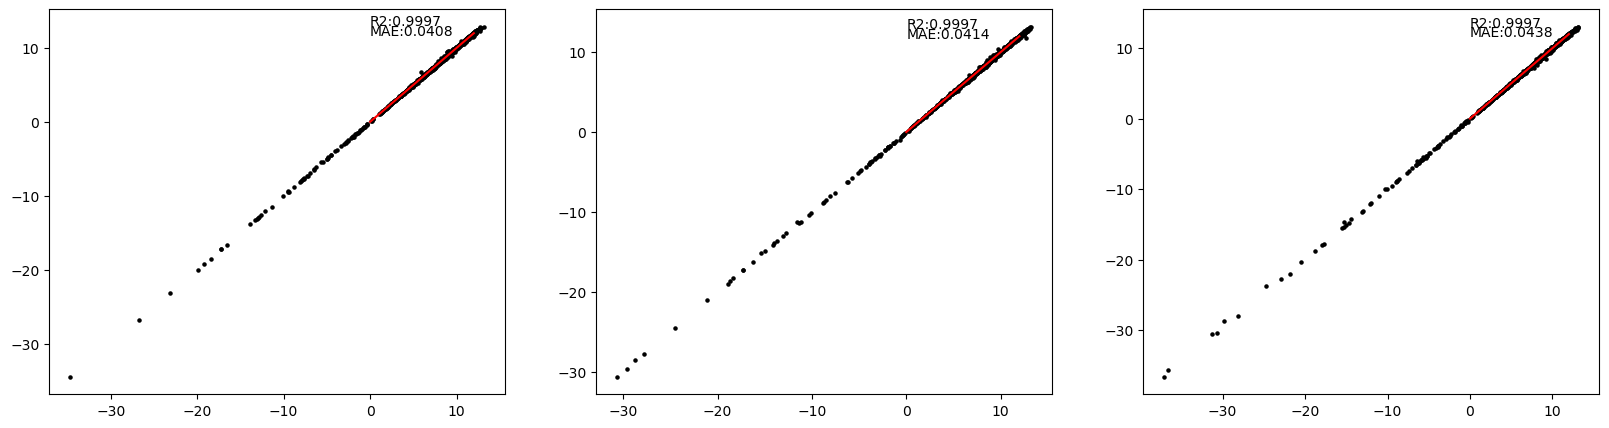

In [98]:
KRR = KernelRidge(**params)
_ = PredPlot_folds(KRR,Tr_x,Tr_y,Te_x,Te_y)

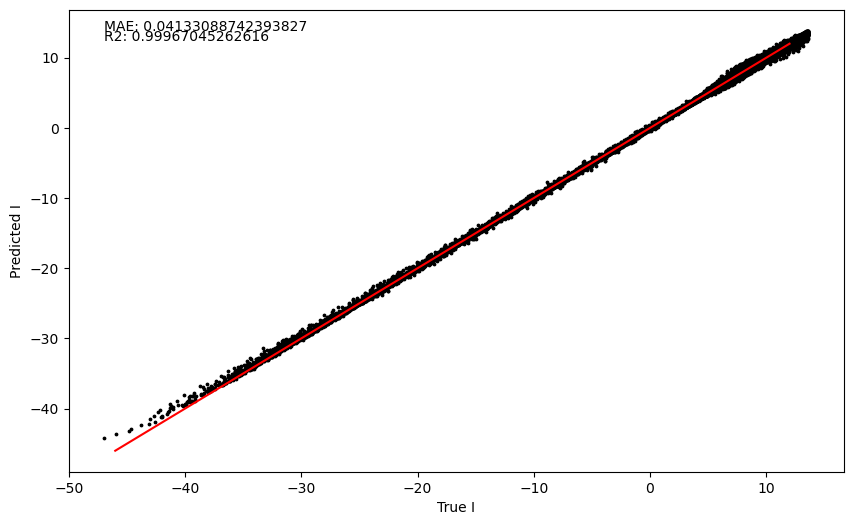

In [99]:
# Can't run on full dataset which is 18M due to memory issues (would need 75GB) but I can do this for 5M dataset. 

Tr_x,Te_x,V_x,Tr_y,Te_y,V_y = get_folds(DF_5M,n_fold=3)
X_train,X_test,X_val,Y_train,Y_test,Y_val = Tr_x[0],Te_x[0],V_x[0],Tr_y[0],Te_y[0],V_y[0]
#KRR = KernelRidge(**params)

#KRR.fit(X_train,Y_train)
pred = KRR.predict(X_test)
MAE = mean_absolute_error(Y_test,pred)
R2 = r2_score(Y_test,pred)

Plot_Pred(Y_test,pred)

# 30K set

In [5]:
from time import time
start = time()
# Using above results I will repeat the search with limited parameters
DF_30k = DF_full.sample(30000,random_state=0)
Tr_x,Te_x,V_x,Tr_y,Te_y,V_y = get_folds(DF_30k,n_fold=3)

X_train,X_test,X_val,Y_train,Y_test,Y_val = Tr_x[0],Te_x[0],V_x[0],Tr_y[0],Te_y[0],V_y[0]
study = optuna.create_study(direction='minimize', study_name='regression')

#This function will use previous best parameters as starting point
for T in TRIALS:
    study.enqueue_trial(T)
    
param = study.optimize(objective, n_trials=50,gc_after_trial=True)
params = study.best_params
val = study.best_value
print('Best value:',val)
print('Best parameters:\n',params)
print('Execution time in seconds:',time()-start,'In minutes:',(time()-start)//60)
TRIALS.append(params)

[W 2023-11-08 16:33:16,702] Trial 3 failed with parameters: {'alpha': 0.08534421820496355, 'gamma': 0.7400753070995062, 'kernel': 'rbf'} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "C:\Users\togali\AppData\Local\anaconda3\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\togali\AppData\Local\Temp\ipykernel_18512\3942536884.py", line 8, in objective
    model.fit(X_train, Y_train)
  File "C:\Users\togali\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\togali\AppData\Local\anaconda3\Lib\site-packages\sklearn\kernel_ridge.py", line 210, in fit
    self.dual_coef_ = _solve_cholesky_kernel(K, y, alpha, sample_weight, copy)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

KeyboardInterrupt: 

Fold 0 MAE: 0.027594017993718852
Fold 1 MAE: 0.026050544349974034
Fold 2 MAE: 0.02610984882093794
Mean R2: 0.9998666666666667
Mean MAE: 0.0266


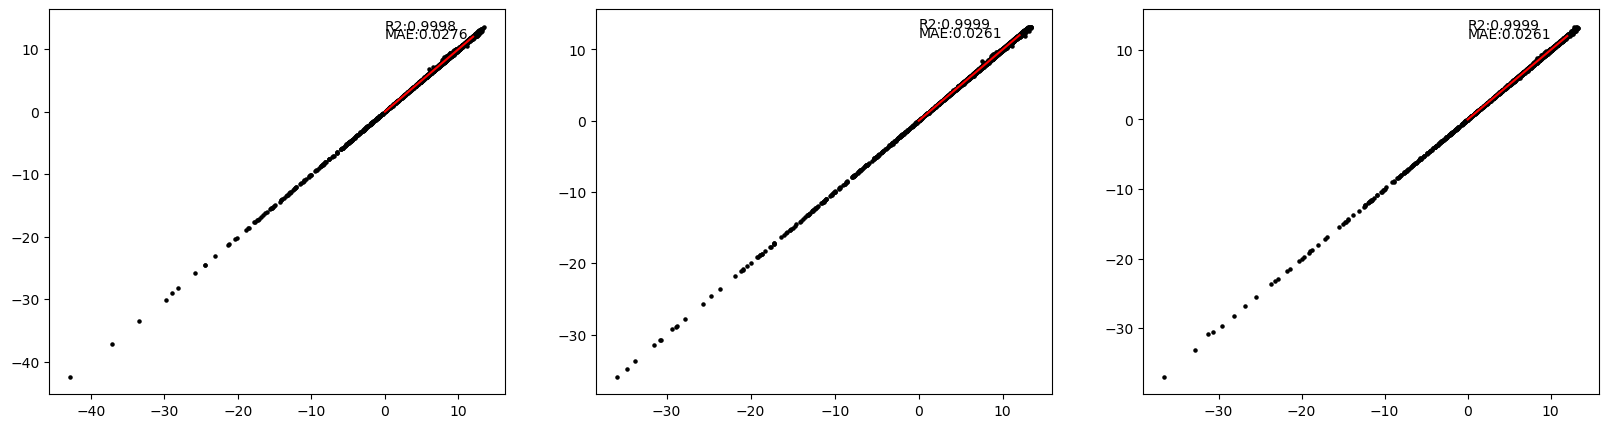

In [6]:
params = {'alpha': 1.003933272031719e-06, 'gamma': 0.22320911359899115, 'kernel': 'chi2'}
KRR = KernelRidge(**params)
_ = PredPlot_folds(KRR,Tr_x,Tr_y,Te_x,Te_y)

In [ ]:
# Can't run on full dataset which is 18M due to memory issues (would need 75GB) but I can do this for 5M dataset. 

Tr_x,Te_x,V_x,Tr_y,Te_y,V_y = get_folds(DF_5M,n_fold=3)
X_train,X_test,X_val,Y_train,Y_test,Y_val = Tr_x[0],Te_x[0],V_x[0],Tr_y[0],Te_y[0],V_y[0]
#KRR = KernelRidge(**params)

#KRR.fit(X_train,Y_train)
pred = KRR.predict(X_test)
MAE = mean_absolute_error(Y_test,pred)
R2 = r2_score(Y_test,pred)

Plot_Pred(Y_test,pred)